Number of Brand Classes: 11
Number of Task Classes: 27
Removing classes with fewer than 2 samples: [5, 1, 8, 7]
New dataset shape after removal: (51, 9)

Training set shape: (30, 9)
Validation set shape: (10, 9)
Test set shape: (11, 9)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                  

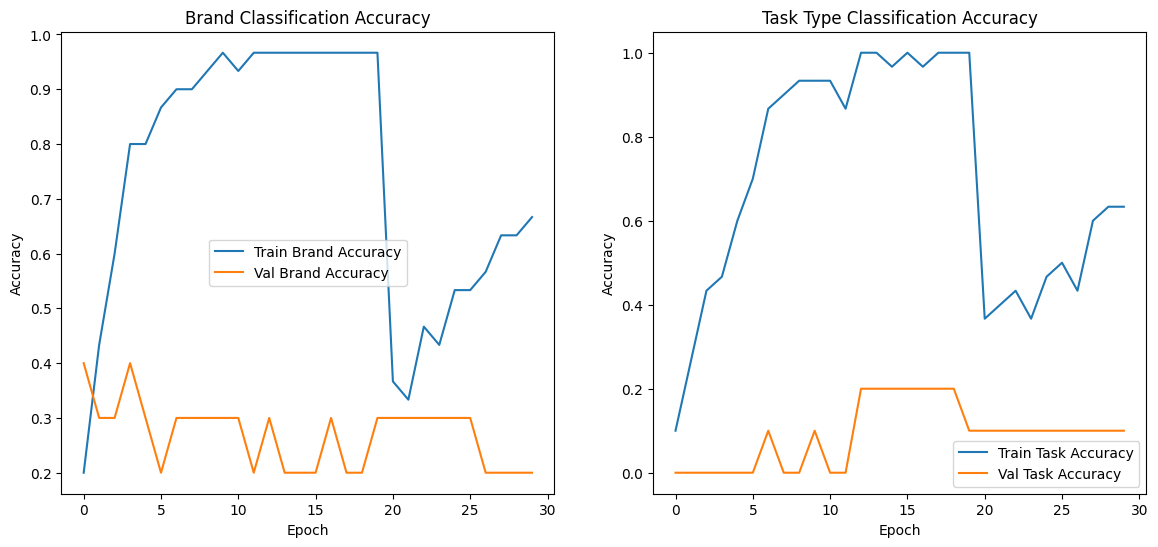

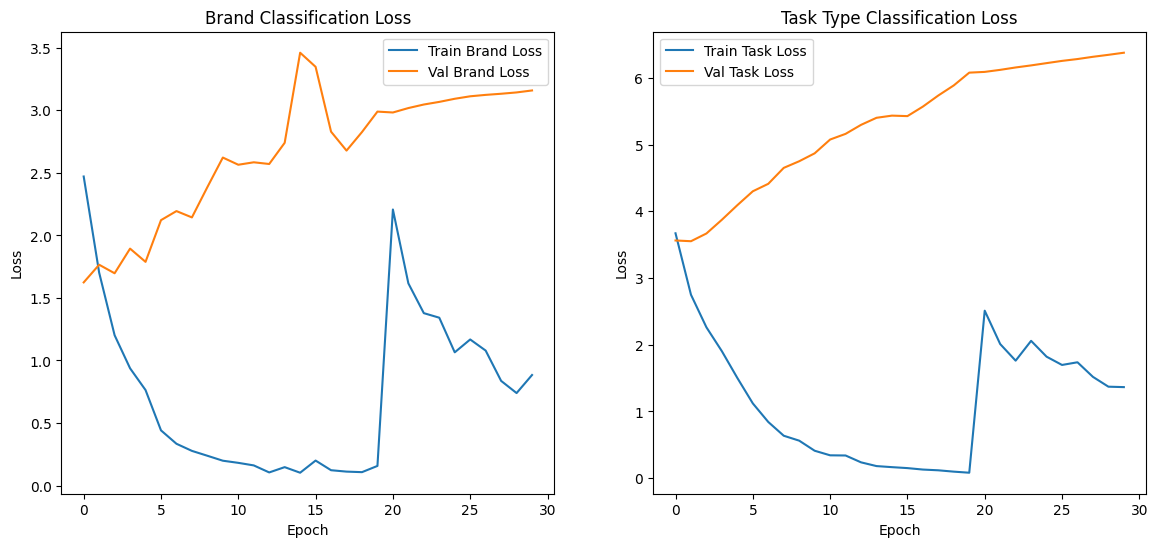

1/1 [==============================] - 0s 69ms/step


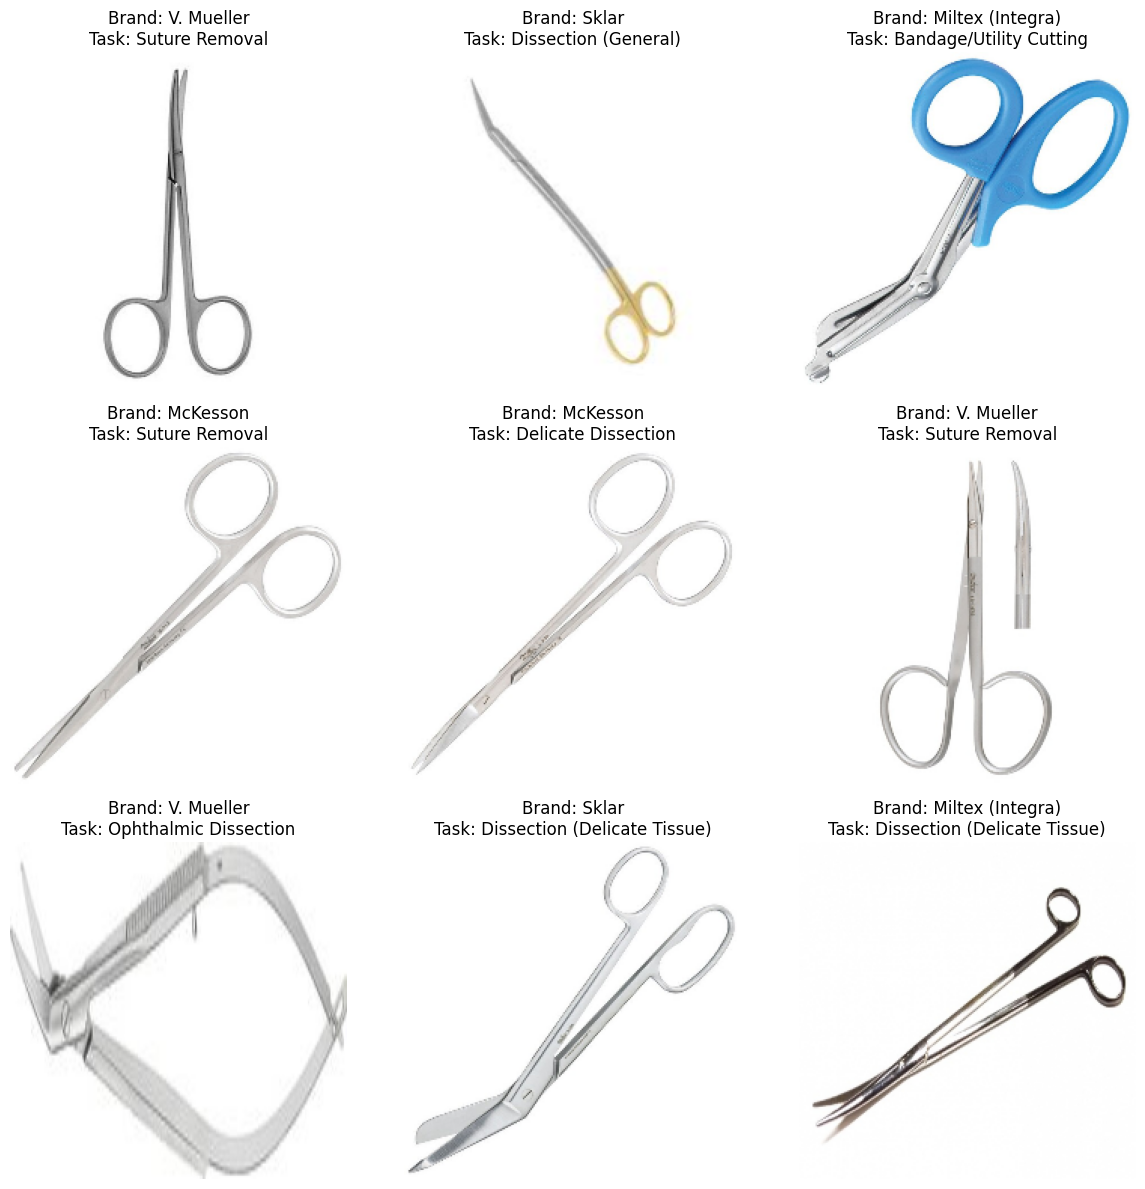

In [3]:
# ==========================
# 1. Import Libraries
# ==========================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import jaccard_score, f1_score

# Set logging level if you want to suppress TF deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# ==========================
# 2. Load and Preprocess CSV Data
# ==========================
# Update the path to your CSV as needed.
csv_path = r"C:\Users\musab\DLScissor\data\dataset_updated.csv"
df = pd.read_csv(csv_path, encoding='latin-1')

# If the image paths in the CSV are relative (e.g., "images/1.jpg"),
# and your images are located in C:\Users\musab\DLScissor\images\,
# update the image paths accordingly.
# Uncomment and modify if necessary:
# df['Image Path'] = df['Image Path'].apply(lambda x: os.path.join('images', os.path.basename(x)))

# Encode categorical labels for both Brand and Task Type.
brand_le = LabelEncoder()
task_le = LabelEncoder()
df['Brand_encoded'] = brand_le.fit_transform(df['Brand'])
df['Task_encoded'] = task_le.fit_transform(df['Task Type'])

# For later use, determine the number of classes
num_brand_classes = len(brand_le.classes_)
num_task_classes = len(task_le.classes_)
print("Number of Brand Classes:", num_brand_classes)
print("Number of Task Classes:", num_task_classes)

# ==========================
# 3. Stratified Train/Validation/Test Split
# ==========================
# Optionally remove classes with fewer than 2 samples (needed for stratification).
brand_counts = df['Brand_encoded'].value_counts()
classes_to_remove = brand_counts[brand_counts < 2].index.tolist()
if classes_to_remove:
    print("Removing classes with fewer than 2 samples:", classes_to_remove)
    df = df[~df['Brand_encoded'].isin(classes_to_remove)]
    print("New dataset shape after removal:", df.shape)
else:
    print("All classes have at least 2 samples.")

# Split into train and temp (which will be split into val and test)
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42, stratify=df['Brand_encoded'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print("\nTraining set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
print("Test set shape:", test_df.shape)

# ==========================
# 4. Build tf.data.Dataset Pipeline
# ==========================
# Define constants
IMG_SIZE = (224, 224)  # Width, Height
BATCH_SIZE = 8

def load_and_preprocess_image(img_path):
    """
    Reads an image from disk, decodes it, resizes, and applies MobileNetV2 preprocessing.
    """
    # Read the raw file
    img = tf.io.read_file(img_path)
    # Decode to 3 channel image (adjust if your images are in a different format)
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize image
    img = tf.image.resize(img, IMG_SIZE)
    # Preprocess using MobileNetV2 preprocessing
    img = preprocess_input(img)
    return img

def create_dataset(df, batch_size=BATCH_SIZE, augment=False, shuffle=True):
    """
    Given a dataframe, creates a tf.data.Dataset that returns an image and a two-output label dictionary.
    """
    # Extract file paths and labels from the dataframe
    image_paths = df['Image Path'].values
    brand_labels = df['Brand_encoded'].values
    task_labels = df['Task_encoded'].values

    ds = tf.data.Dataset.from_tensor_slices((image_paths, brand_labels, task_labels))
    
    def process_path(path, brand_label, task_label):
        img = load_and_preprocess_image(path)
        if augment:
            # Simple augmentations for training (adjust as needed)
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, max_delta=0.1)
        # One-hot encode labels. Use depth from the training dataframe.
        brand_onehot = tf.one_hot(brand_label, depth=num_brand_classes)
        task_onehot = tf.one_hot(task_label, depth=num_task_classes)
        return img, {'brand_output': brand_onehot, 'task_output': task_onehot}

    ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataset(train_df, augment=True, shuffle=True)
val_ds   = create_dataset(val_df, augment=False, shuffle=False)
test_ds  = create_dataset(test_df, augment=False, shuffle=False)

# ==========================
# 5. Build the Multi-Output Model
# ==========================
# Load MobileNetV2 without top layers. We freeze the base model for initial training.
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=IMG_SIZE+(3,))
base_model.trainable = False  # Freeze for initial training

# Global feature extraction
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)

# Branch for Brand classification
brand_branch = Dense(128, activation='relu')(x)
brand_output = Dense(num_brand_classes, activation='softmax', name='brand_output')(brand_branch)

# Branch for Task Type classification
task_branch = Dense(128, activation='relu')(x)
task_output = Dense(num_task_classes, activation='softmax', name='task_output')(task_branch)

# Construct the full model
model = Model(inputs=base_model.input, outputs=[brand_output, task_output])
model.summary()

# ==========================
# 6. Compile the Model
# ==========================
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={'brand_output': 'categorical_crossentropy',
                    'task_output': 'categorical_crossentropy'},
              metrics={'brand_output': 'accuracy',
                       'task_output': 'accuracy'})

# ==========================
# 7. Train the Model (Initial Training)
# ==========================
initial_epochs = 20  # Adjust epochs as needed
history = model.fit(train_ds, validation_data=val_ds, epochs=initial_epochs)

# ==========================
# 8. Fine-Tuning (Optional)
# ==========================
# Unfreeze the base_model from a certain layer onward
base_model.trainable = True
fine_tune_at = 100  # Freeze layers before this index

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss={'brand_output': 'categorical_crossentropy',
                    'task_output': 'categorical_crossentropy'},
              metrics={'brand_output': 'accuracy',
                       'task_output': 'accuracy'})

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_finetune = model.fit(train_ds, validation_data=val_ds,
                             epochs=total_epochs,
                             initial_epoch=history.epoch[-1] + 1)

# ==========================
# 9. Evaluate the Model on Test Data with Additional Metrics
# ==========================
# Obtain true and predicted labels from test dataset
y_true_brand = []
y_pred_brand = []
y_true_task = []
y_pred_task = []

for imgs, labels in test_ds:
    preds = model.predict(imgs)
    y_true_brand.extend(np.argmax(labels['brand_output'], axis=1))
    y_true_task.extend(np.argmax(labels['task_output'], axis=1))
    y_pred_brand.extend(np.argmax(preds[0], axis=1))
    y_pred_task.extend(np.argmax(preds[1], axis=1))

# Compute metrics for Brand output
jaccard_brand = jaccard_score(y_true_brand, y_pred_brand, average='macro')
dice_brand    = f1_score(y_true_brand, y_pred_brand, average='macro')
# Compute metrics for Task output
jaccard_task = jaccard_score(y_true_task, y_pred_task, average='macro')
dice_task    = f1_score(y_true_task, y_pred_task, average='macro')

print("\n--- Test Metrics ---")
print("Brand Classification - Jaccard Index: {:.4f}, Dice Coefficient: {:.4f}".format(jaccard_brand, dice_brand))
print("Task Type Classification - Jaccard Index: {:.4f}, Dice Coefficient: {:.4f}".format(jaccard_task, dice_task))

# ==========================
# 10. Visualize Training History
# ==========================
# Combine history from initial training and fine-tuning:
def combine_history(h1, h2, key):
    return h1.history[key] + h2.history[key]

epochs_range = range(total_epochs)

# Plot Accuracy for both outputs
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
train_brand_acc = combine_history(history, history_finetune, 'brand_output_accuracy')
val_brand_acc   = combine_history(history, history_finetune, 'val_brand_output_accuracy')
plt.plot(epochs_range, train_brand_acc, label='Train Brand Accuracy')
plt.plot(epochs_range, val_brand_acc, label='Val Brand Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Brand Classification Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
train_task_acc = combine_history(history, history_finetune, 'task_output_accuracy')
val_task_acc   = combine_history(history, history_finetune, 'val_task_output_accuracy')
plt.plot(epochs_range, train_task_acc, label='Train Task Accuracy')
plt.plot(epochs_range, val_task_acc, label='Val Task Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Task Type Classification Accuracy')
plt.legend()
plt.show()

# Plot Loss for both outputs
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
train_brand_loss = combine_history(history, history_finetune, 'brand_output_loss')
val_brand_loss   = combine_history(history, history_finetune, 'val_brand_output_loss')
plt.plot(epochs_range, train_brand_loss, label='Train Brand Loss')
plt.plot(epochs_range, val_brand_loss, label='Val Brand Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Brand Classification Loss')
plt.legend()

plt.subplot(1, 2, 2)
train_task_loss = combine_history(history, history_finetune, 'task_output_loss')
val_task_loss   = combine_history(history, history_finetune, 'val_task_output_loss')
plt.plot(epochs_range, train_task_loss, label='Train Task Loss')
plt.plot(epochs_range, val_task_loss, label='Val Task Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Task Type Classification Loss')
plt.legend()
plt.show()

# ==========================
# 11. Display Sample Predictions on Test Images
# ==========================
# For visualization, randomly select a few images from the test set.
import random

# Convert test_df to a list for random sampling
sample_df = test_df.sample(n=9, random_state=42)

plt.figure(figsize=(12, 12))
for i, (_, row) in enumerate(sample_df.iterrows()):
    img_path = row['Image Path']
    # Load image using cv2, then convert for plt.imshow
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMG_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Prepare image for prediction (preprocess in the same way as training)
    img_input = preprocess_input(np.expand_dims(img.astype(np.float32), axis=0))
    pred_brand, pred_task = model.predict(img_input)
    pred_brand_label = brand_le.inverse_transform([np.argmax(pred_brand)])[0]
    pred_task_label = task_le.inverse_transform([np.argmax(pred_task)])[0]
    
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(f"Brand: {pred_brand_label}\nTask: {pred_task_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()
